In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

import numpy as np
import matplotlib.pyplot as plt

import sys 
sys.path.append('../src')

from mechanical_systems import DoubleMassSpring
from plot_utils import plot_canonical_time_series
from autoregressive import autoregressive_rollout_ivp

from models import HamiltonianNeuralNetwork, HamiltonianDynamics, MLP

In [2]:
device = torch.device("cpu")
# device = torch.device("mps")
print("Device: ", device)

Device:  cpu


In [ ]:
system = DoubleMassSpring(
    k1=10.,
    k2=10.,
)

n_simulations = 1
t_init = 0
t_final = 20
n_steps = 100 * (t_final - t_init)

t_span = (t_init, t_final)
t_eval = np.linspace(t_init, t_final, n_steps)

dataset, inputs, outputs = system.generate_dataset(
    num_simulations=n_simulations,
    t_span=t_span,
    t_eval=t_eval,
    noise_level=0.015,
    return_trajectories=True,
)

train_size = 200
test_size = len(dataset) - train_size

train_inputs, train_outputs = inputs[:, :train_size, :], outputs[:, :train_size, :]
test_inputs, test_outputs = inputs[:, train_size:, :], outputs[:, train_size:, :]

train_dataset = Subset(dataset, range(train_size))
test_dataset = Subset(dataset, range(train_size, len(dataset)))

print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

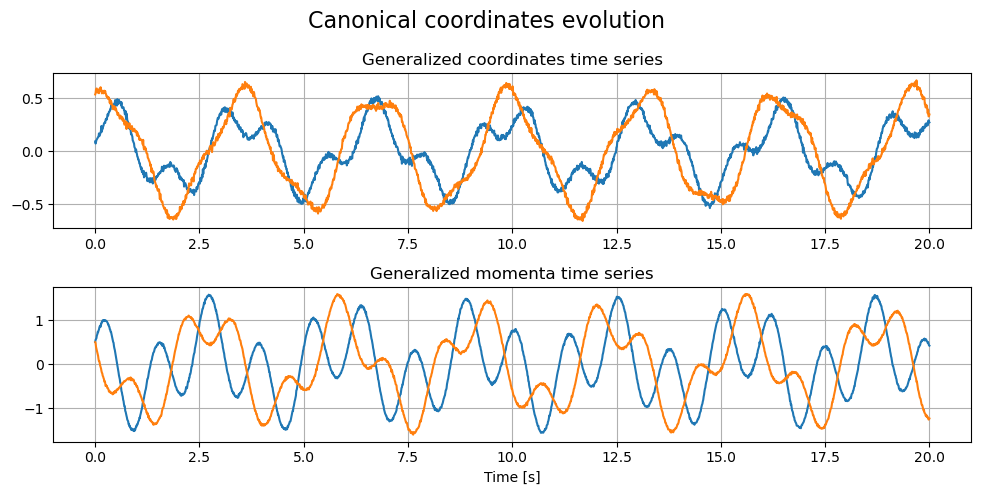

In [6]:
plot_canonical_time_series(t_eval, inputs[0, :, :])

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=len(train_dataset), shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False
)

In [9]:
input_dim = train_inputs[0].shape[1]

hamiltonian_core_model = MLP(
    input_dim=input_dim,
    output_dim=1,
    hidden_dim=256,
    n_hidden_layers=4,
).to(device)

hamiltonian_model = HamiltonianNeuralNetwork(
    input_dim=input_dim,
    core_model=hamiltonian_core_model,
).to(device)

optimizer = torch.optim.Adam(
    hamiltonian_model.parameters(), 
    lr=1e-5,
)

mse_loss_fn = nn.MSELoss()

num_epochs = 2000
train_losses = []
test_losses = []
hamiltonian_model.train()

for epoch in range(num_epochs):
    train_loss = 0.0
    
    # Training loop
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device).requires_grad_(True)
        y_batch = y_batch.to(device).requires_grad_(True)

        optimizer.zero_grad()

        y_pred = hamiltonian_model(x_batch)
        h = hamiltonian_model.compute_hamiltonian(x_batch)

        mse_loss = mse_loss_fn(y_pred, y_batch)
        h_loss = mse_loss_fn(h, torch.zeros_like(h))
        loss = mse_loss + h_loss
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # scheduler.step()

    # # Testing loop
    test_loss = 0.0
    # # Cannot turn off gradient because model uses gradients
    for x_batch, y_batch in test_loader:

        x_batch = x_batch.to(device).requires_grad_(True)
        y_batch = y_batch.to(device).requires_grad_(True)

        y_pred = hamiltonian_model(x_batch)
        h_test = hamiltonian_model.compute_hamiltonian(x_batch)
        
        mse_loss_test = mse_loss_fn(y_pred, y_batch).item()
        h_loss_test = mse_loss_fn(h_test, torch.zeros_like(h_test)).item()
        test_loss += mse_loss_test + h_loss_test


    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f" ---- Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


 ---- Epoch 100/2000
Train Loss: 5.0729, Test Loss: 4.8220
 ---- Epoch 200/2000
Train Loss: 4.9912, Test Loss: 4.7751
 ---- Epoch 300/2000
Train Loss: 4.7836, Test Loss: 4.6582
 ---- Epoch 400/2000
Train Loss: 4.1764, Test Loss: 4.3346
 ---- Epoch 500/2000
Train Loss: 3.1044, Test Loss: 3.7836
 ---- Epoch 600/2000
Train Loss: 2.1462, Test Loss: 3.3046
 ---- Epoch 700/2000
Train Loss: 1.2295, Test Loss: 2.8738
 ---- Epoch 800/2000
Train Loss: 0.5375, Test Loss: 2.3576
 ---- Epoch 900/2000
Train Loss: 0.2370, Test Loss: 1.9452
 ---- Epoch 1000/2000
Train Loss: 0.1296, Test Loss: 1.7098
 ---- Epoch 1100/2000
Train Loss: 0.0878, Test Loss: 1.5824
 ---- Epoch 1200/2000
Train Loss: 0.0697, Test Loss: 1.4905
 ---- Epoch 1300/2000
Train Loss: 0.0600, Test Loss: 1.4241
 ---- Epoch 1400/2000
Train Loss: 0.0521, Test Loss: 1.3638
 ---- Epoch 1500/2000
Train Loss: 0.0500, Test Loss: 1.3035
 ---- Epoch 1600/2000
Train Loss: 0.0508, Test Loss: 1.2478
 ---- Epoch 1700/2000
Train Loss: 0.0517, Test Lo

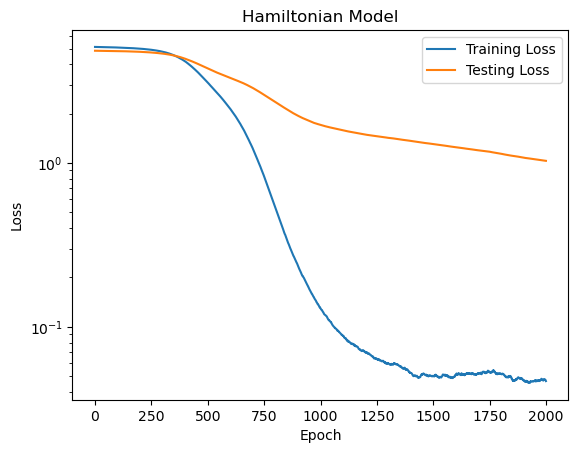

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Hamiltonian Model')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

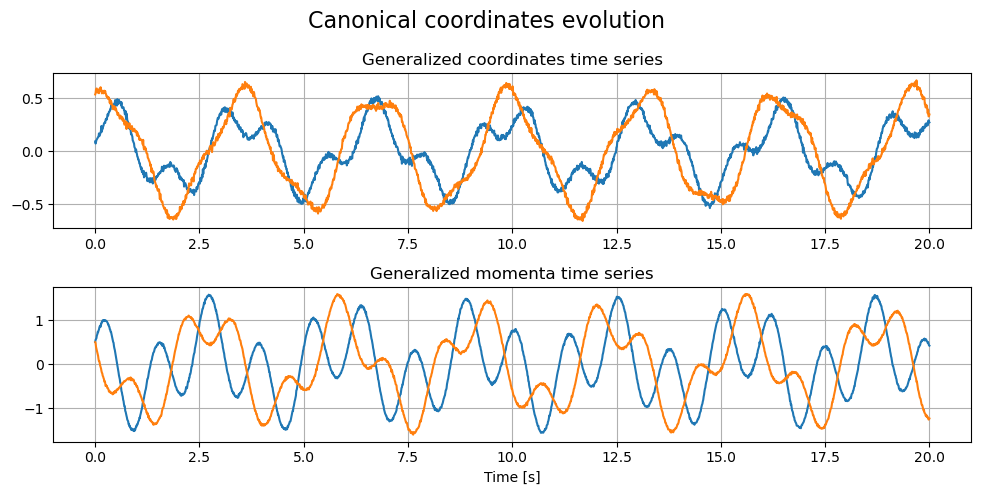

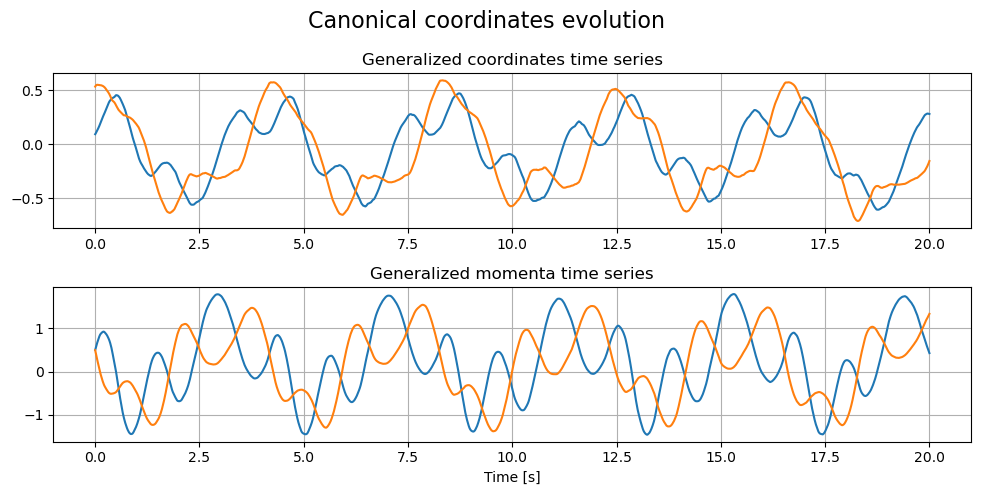

In [11]:
trajectory_truth = inputs[0, :, :]
initial_conditions = trajectory_truth[0, :].requires_grad_(True)
t_span = (t_init, t_final)

trajectory_hamiltonian_model = autoregressive_rollout_ivp(
    model=hamiltonian_model,
    initial_conditions=initial_conditions,
    t_span=t_span,
    n_steps=n_steps,
)

plot_canonical_time_series(t_eval, trajectory_truth)
plot_canonical_time_series(t_eval, trajectory_hamiltonian_model)

In [12]:
baseline_model = MLP(
    input_dim=input_dim,
    hidden_dim=256,
    output_dim=input_dim,
    n_hidden_layers=4,
).to(device)

optimizer = torch.optim.Adam(
    baseline_model.parameters(),
    lr=1e-4,
)
loss_fn = nn.MSELoss()

num_epochs = 2000
train_losses_baseline = []
test_losses_baseline = []
baseline_model.train() 

for epoch in range(num_epochs):
    train_loss = 0.0
    
    # Training loop
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device).requires_grad_(True)
        y_batch = y_batch.to(device).requires_grad_(True)

        optimizer.zero_grad()

        y_pred = baseline_model(x_batch)
        
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses_baseline.append(train_loss)

    # Testing loop
    test_loss = 0.0
    # Cannot turn off gradient because model uses gradients
    for x_batch, y_batch in test_loader:

        x_batch = x_batch.to(device).requires_grad_(True)
        y_batch = y_batch.to(device).requires_grad_(True)

        y_pred = baseline_model(x_batch)

        test_loss += loss_fn(y_pred, y_batch).item()

    test_loss /= len(test_loader)
    test_losses_baseline.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f" ---- Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

 ---- Epoch 100/2000
Train Loss: 0.5289, Test Loss: 5.0679
 ---- Epoch 200/2000
Train Loss: 0.0138, Test Loss: 4.3970
 ---- Epoch 300/2000
Train Loss: 0.0092, Test Loss: 4.5030
 ---- Epoch 400/2000
Train Loss: 0.0078, Test Loss: 4.6108
 ---- Epoch 500/2000
Train Loss: 0.0072, Test Loss: 4.7335
 ---- Epoch 600/2000
Train Loss: 0.0068, Test Loss: 4.8633
 ---- Epoch 700/2000
Train Loss: 0.0064, Test Loss: 5.0057
 ---- Epoch 800/2000
Train Loss: 0.0061, Test Loss: 5.1355
 ---- Epoch 900/2000
Train Loss: 0.0058, Test Loss: 5.2598
 ---- Epoch 1000/2000
Train Loss: 0.0056, Test Loss: 5.3801
 ---- Epoch 1100/2000
Train Loss: 0.0053, Test Loss: 5.4982
 ---- Epoch 1200/2000
Train Loss: 0.0051, Test Loss: 5.6100
 ---- Epoch 1300/2000
Train Loss: 0.0050, Test Loss: 5.7165
 ---- Epoch 1400/2000
Train Loss: 0.0047, Test Loss: 5.8100
 ---- Epoch 1500/2000
Train Loss: 0.0046, Test Loss: 5.9079
 ---- Epoch 1600/2000
Train Loss: 0.0043, Test Loss: 5.9870
 ---- Epoch 1700/2000
Train Loss: 0.0042, Test Lo

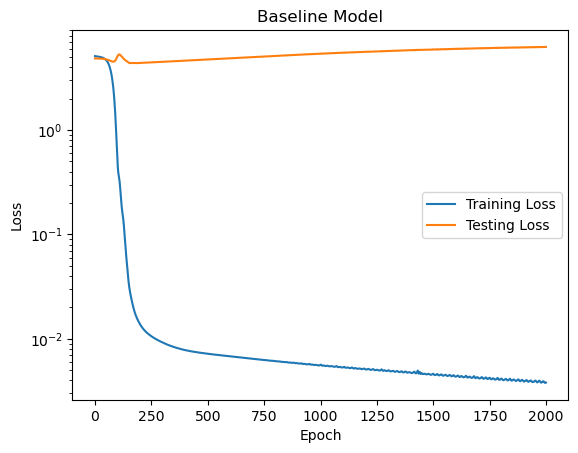

In [13]:
plt.plot(train_losses_baseline, label='Training Loss')
plt.plot(test_losses_baseline, label='Testing Loss')
plt.title('Baseline Model')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

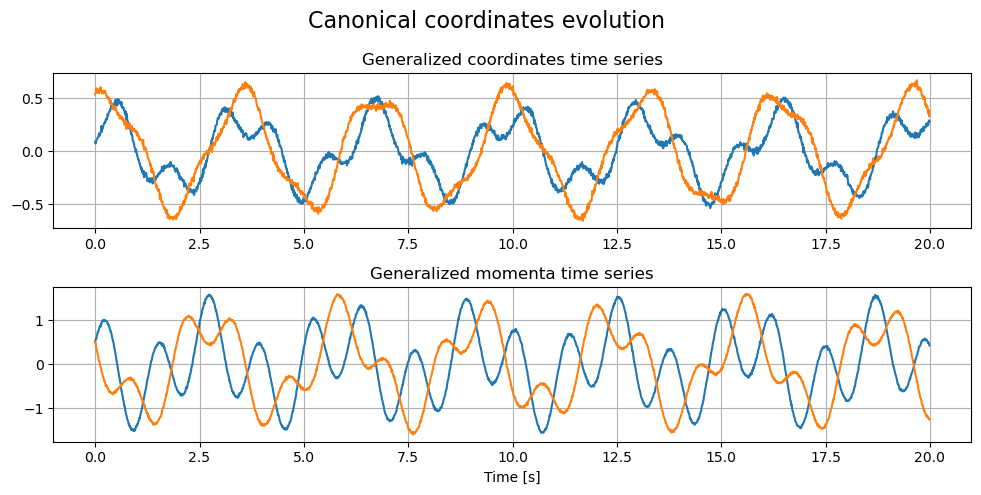

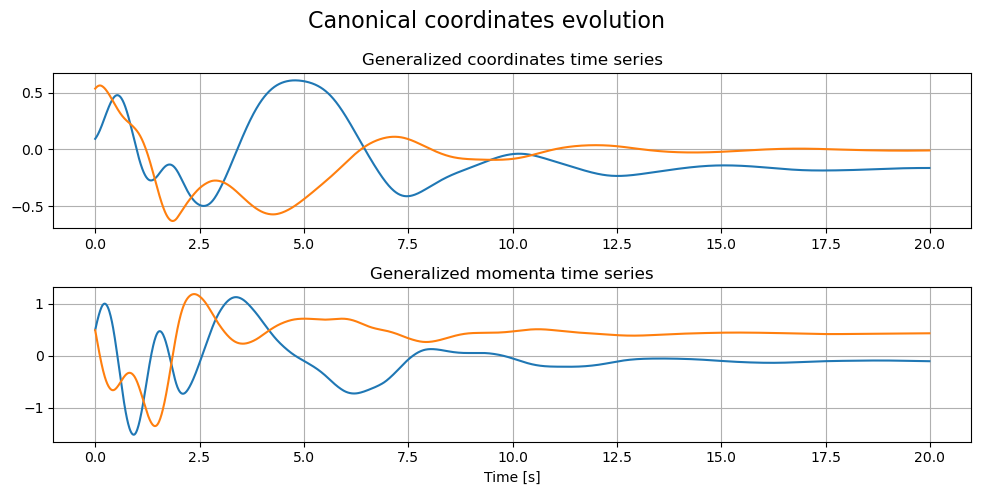

In [14]:
trajectory_truth = inputs[0, :, :]
initial_conditions = trajectory_truth[0, :].requires_grad_(True)
t_span = (t_init, t_final)

trajectory_baseline_model = autoregressive_rollout_ivp(
    model=baseline_model,
    initial_conditions=initial_conditions,
    t_span=t_span,
    n_steps=n_steps,
)

t_horizon = -1
plot_canonical_time_series(t_eval[:t_horizon], trajectory_truth[:t_horizon])
plot_canonical_time_series(t_eval[:t_horizon], trajectory_baseline_model[:t_horizon])

In [ ]:
from torchdiffeq import odeint

hamiltonian_core_model = MLP(
    input_dim=input_dim,
    output_dim=1,
    hidden_dim=256,
    n_hidden_layers=4,
).to(device)

hamiltonian_neural_ode_model = HamiltonianNeuralNetwork(
    input_dim=input_dim,
    core_model=hamiltonian_core_model,
).to(device)


dynamics = HamiltonianDynamics(hamiltonian_neural_ode_model).to(device)

optimizer = torch.optim.Adam(
    dynamics.parameters(), 
    lr=5e-3,
)

num_epochs = 20
train_losses = []
test_losses = []
dynamics.train()

y0 = inputs[0, 0, :].requires_grad_(True)
y_target = inputs[0, :train_size, :].requires_grad_(True)

for epoch in range(num_epochs):
    
    optimizer.zero_grad()

    y_pred = odeint(
        func=dynamics,
        y0=y0,
        t=torch.tensor(t_eval)[:len(y_target)],
    ).requires_grad_(True)

    train_loss = mse_loss_fn(y_pred, y_target)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    if (epoch + 1) % 1 == 0:
        print(f" ---- Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")


 ---- Epoch 1/20
Train Loss: 0.7156
 ---- Epoch 2/20
Train Loss: 0.6132
 ---- Epoch 3/20
Train Loss: 0.3622
 ---- Epoch 4/20
Train Loss: 0.2811
 ---- Epoch 5/20
Train Loss: 0.3030
 ---- Epoch 6/20
Train Loss: 0.2511
 ---- Epoch 7/20
Train Loss: 0.2644
 ---- Epoch 8/20
Train Loss: 0.2249
 ---- Epoch 9/20
Train Loss: 0.2182


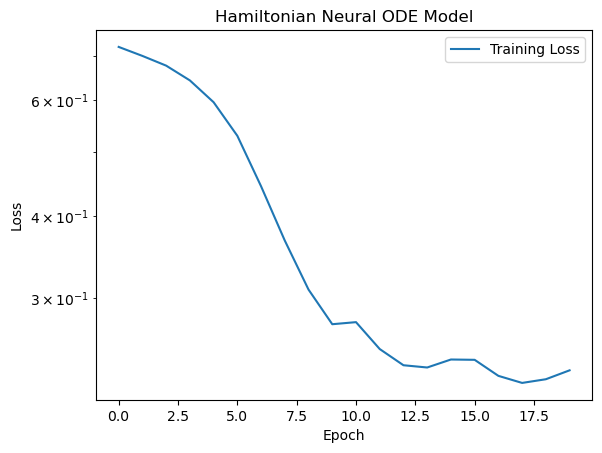

In [16]:
plt.plot(train_losses, label='Training Loss')
plt.title('Hamiltonian Neural ODE Model')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

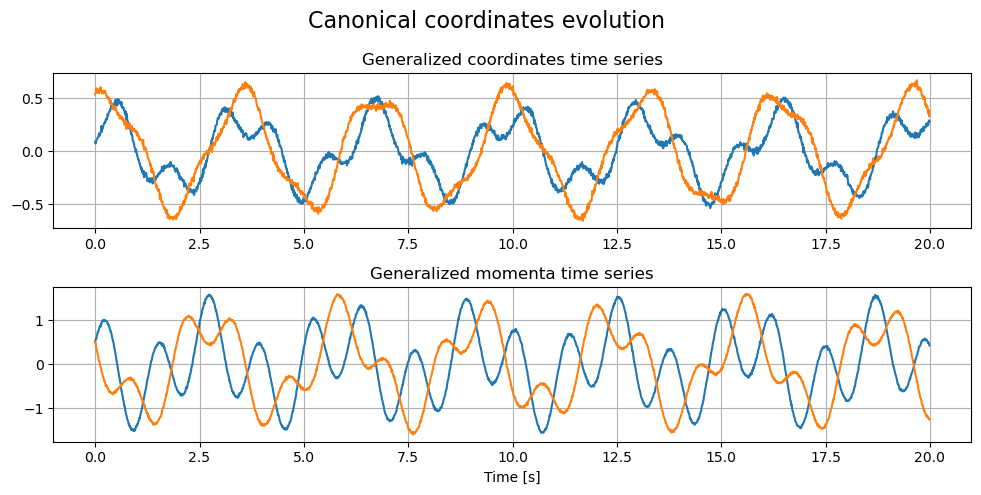

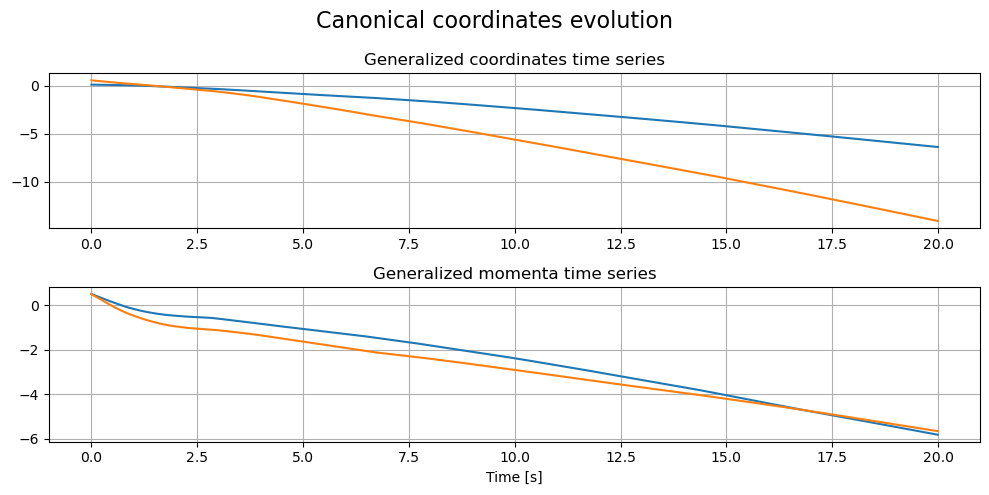

In [ ]:
t_span = (t_init, t_final)
t_eval = np.linspace(t_init, t_final, n_steps)

trajectory_truth = inputs[0, :, :]
initial_conditions = trajectory_truth[0, :].requires_grad_(True)

trajectory_hamiltonian_neural_ode_model = odeint(
    func=dynamics,
    y0=initial_conditions,
    t=torch.tensor(t_eval),
).detach().numpy()

plot_canonical_time_series(t_eval, trajectory_truth)
plot_canonical_time_series(t_eval, trajectory_hamiltonian_neural_ode_model)